# Exploration Data Analysis (EDA) 1

## Import Library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from IPython.display import display
from collections import Counter
from wordcloud import STOPWORDS, WordCloud

## Overview Dataset

In [2]:
#start_time = time.time()
#file_path = "/kaggle/input/yelp-business-dataset/yelp dataset reviews.json"
#df = pd.read_json(file_path, lines=True)
#end_time = time.time()

#print(f"Informasi Dataset    : {len(df):,} baris dan {len(df.columns)} kolom")
#print(f"Waktu membaca dataset: {end_time - start_time:.2f} detik")

# Exploration Data Analysis (EDA) 2

## Overview Dataset

In [3]:
start_time = time.time()
file_path = "/kaggle/input/yelp-dataset-sentiment-analysis/data transform.parquet"
df2 = pd.read_parquet(file_path)
end_time = time.time()

print(f"Informasi Dataset    : {len(df2):,} baris dan {len(df2.columns)} kolom")
print(f"Waktu membaca dataset: {end_time - start_time:.2f} detik")

Informasi Dataset    : 4,724,684 baris dan 7 kolom
Waktu membaca dataset: 26.57 detik


In [4]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4724684 entries, 0 to 4724683
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date             object 
 1   text             object 
 2   city             object 
 3   state            object 
 4   review_stars     float64
 5   sentiment        int32  
 6   sentiment_label  object 
dtypes: float64(1), int32(1), object(5)
memory usage: 234.3+ MB
None


In [5]:
print(df2.head(5))

                  date                                               text  \
0  2018-07-07 22:09:11  If you decide to eat here, just be aware it is...   
1  2014-02-05 20:30:30  Family diner. Had the buffet. Eclectic assortm...   
2  2015-01-04 00:01:03  Wow!  Yummy, different,  delicious.   Our favo...   
3  2017-01-14 20:54:15  Cute interior and owner (?) gave us tour of up...   
4  2015-09-23 23:10:31  I am a long term frequent customer of this est...   

           city state  review_stars  sentiment sentiment_label  
0   North Wales    PA           3.0          1         Neutral  
1        Tucson    AZ           3.0          1         Neutral  
2  Philadelphia    PA           5.0          2        Positive  
3   New Orleans    LA           4.0          2        Positive  
4  Philadelphia    PA           1.0          0        Negative  


## Jumlah Masing-masing Label Sentimen

In [6]:
sentiment_counts = df2["sentiment_label"].value_counts().reset_index()
sentiment_counts.columns = ["Sentiment", "Count"]
print(sentiment_counts)

  Sentiment    Count
0  Positive  3209836
1  Negative   971722
2   Neutral   543126


## Distribusi Sentimen Secara Keseluruhan

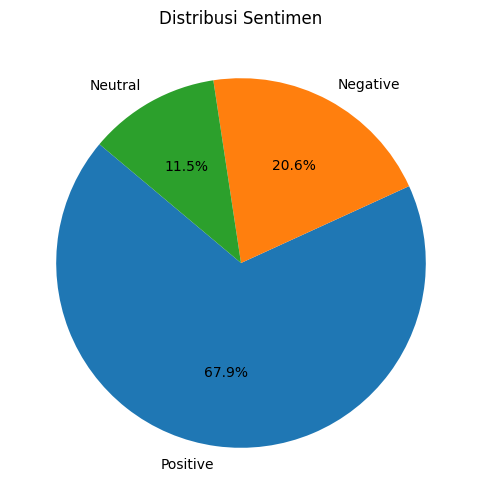

In [7]:
counts = df2["sentiment_label"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Distribusi Sentimen")
plt.show()

Menunjukkan komposisi label sentimen (Positive, Neutral, Negative). Jika salah satu dominan, ini bisa menunjukkan dataset tidak seimbang. Hasilnya ternyata pada label Positive sangat dominan dibandingkan label Negative dan Neutral

## Distribusi Sentimen per State

<Figure size 1400x600 with 0 Axes>

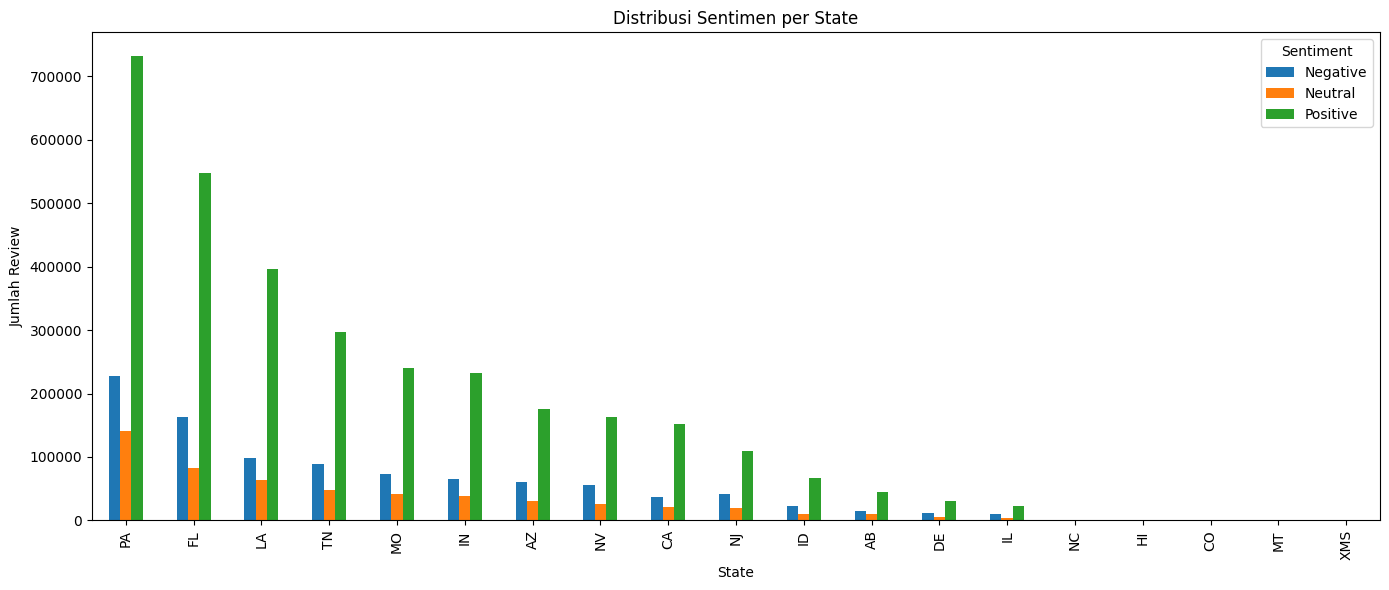

In [8]:
# Hitung jumlah review per state dan sentimen
sentiment_per_state = (
    df2.groupby(["state", "sentiment_label"])
      .size()
      .reset_index(name="count")
)

# Hitung total review per state
total_per_state = (
    sentiment_per_state.groupby("state")["count"]
    .sum()
    .reset_index()
    .sort_values(by="count", ascending=False)
)

# Urutkan state berdasarkan total review terbanyak
state_order = (
    sentiment_per_state.groupby("state")["count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

# Plot bar chart
plt.figure(figsize=(14,6))
pivot_df = (
    sentiment_per_state
    .pivot(index="state", columns="sentiment_label", values="count")
    .fillna(0)
)
pivot_df = pivot_df.loc[state_order]

pivot_df.plot(kind="bar", stacked=False, figsize=(14,6))
plt.title("Distribusi Sentimen per State")
plt.xlabel("State")
plt.ylabel("Jumlah Review")
plt.legend(title="Sentiment")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
print("Jumlah Total Review per State")
display(total_per_state.style.set_properties(**{'text-align': 'center'})
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
        .format({'count': '{:,}'}))

Jumlah Total Review per State


,state,count
16,PA,"1,100,276"
5,FL,"792,141"
10,LA,"558,347"
17,TN,"434,709"
11,MO,"354,613"
9,IN,"335,843"
1,AZ,"267,088"
15,NV,"243,649"
2,CA,"211,748"
14,NJ,"171,206"


Menunjukkan jumlah review tiap state berdasarkan kategori sentimen. Biasanya terlihat bahwa beberapa state mendominasi data.Terlihat hasilnya beberapa state seperti PA , FL, LA, TN, MO, dan IN memiliki jumlah review yang jauh lebih banyak dibandingkan state lainnya, sehingga mendominasi distribusi data.

In [10]:
#Tabel per state pada tiap sentiment
sentiment_sorted = sentiment_per_state.sort_values(by=["state", "sentiment_label"])
print("Jumlah Review per State per Sentiment")
display(sentiment_sorted.style.set_properties(**{'text-align': 'center'})
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
        .format({'count': '{:,}'}))

Jumlah Review per State per Sentiment


,state,sentiment_label,count
0,AB,Negative,"14,239"
1,AB,Neutral,"10,420"
2,AB,Positive,"44,223"
3,AZ,Negative,"61,095"
4,AZ,Neutral,"29,920"
5,AZ,Positive,"176,073"
6,CA,Negative,"37,587"
7,CA,Neutral,"21,904"
8,CA,Positive,"152,257"
9,CO,Neutral,6


## Distribusi Persentase Sentimen per State (Top 6)

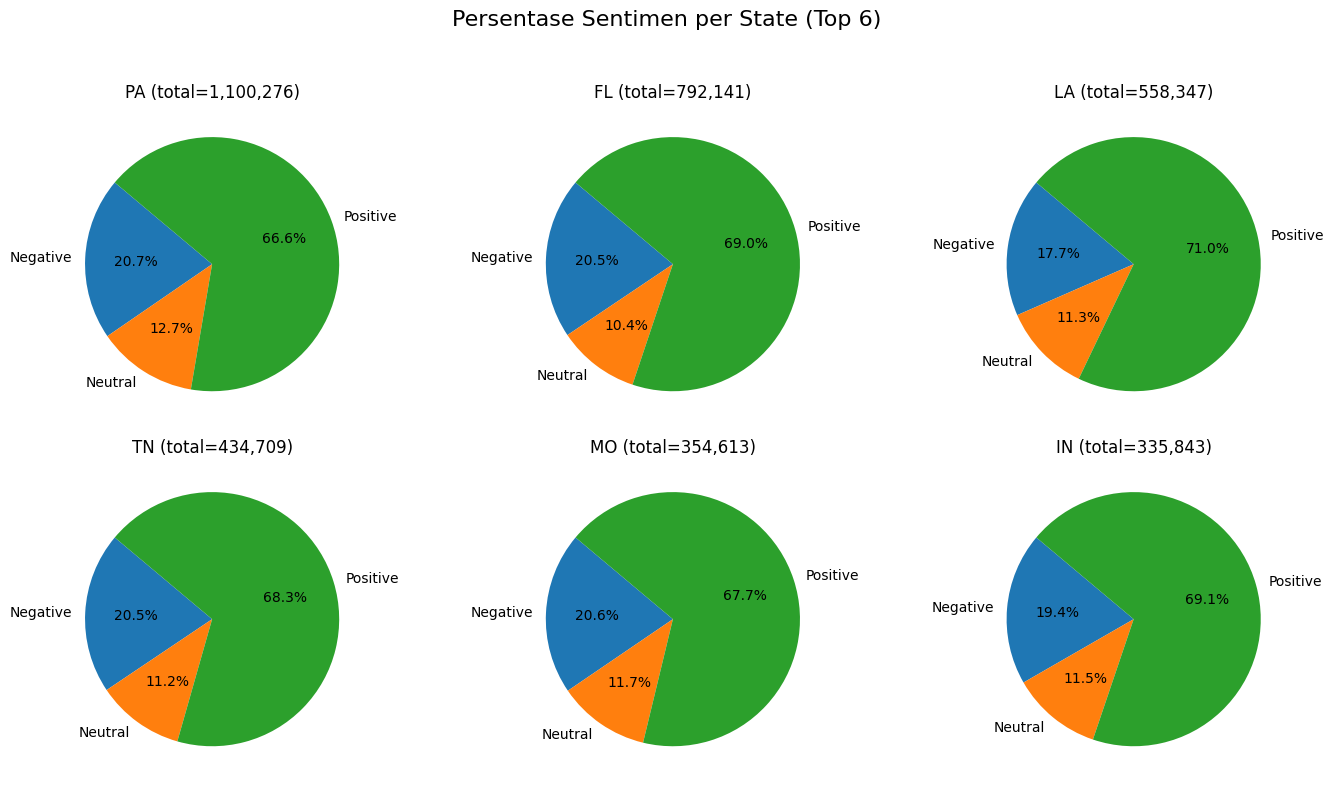

In [11]:
# Memakai top 6 state dengan review terbanyak
top_states = state_order[:6]
sentiment_top = sentiment_per_state[sentiment_per_state["state"].isin(top_states)]

# Plot pie chart per state
fig, axes = plt.subplots(2, 3, figsize=(14,8))
axes = axes.flatten()

for i, state in enumerate(top_states):
    data_state = sentiment_top[sentiment_top["state"] == state]
    axes[i].pie(
        data_state["count"],
        labels=data_state["sentiment_label"],
        autopct="%1.1f%%",
        startangle=140
    )
    axes[i].set_title(f"{state} (total={data_state['count'].sum():,})")

plt.suptitle("Persentase Sentimen per State (Top 6)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Visualisasi ini menunjukkan persentase perbandingan sentimen di top 6 state dengan jumlah review terbanyak. Terlihat di top 6 state memiliki review positif yang sangat mendominasi dibandingkan review negative dan neutral sehingga sangat imbalance

# Exploration Data Analysis (EDA) 3

## Membaca Dataset

In [12]:
start_time = time.time()
file_path = "/kaggle/input/yelp-dataset-sentiment-analysis/data transform 2.parquet"
df3 = pd.read_parquet(file_path)
end_time = time.time()

print(f"Informasi Dataset    : {len(df3):,} baris dan {len(df3.columns)} kolom")
print(f"Waktu membaca dataset: {end_time - start_time:.2f} detik")

Informasi Dataset    : 60,000 baris dan 7 kolom
Waktu membaca dataset: 0.60 detik


## Overview Dataset

In [13]:
df3.info()
df3.head(100000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             60000 non-null  object 
 1   text             60000 non-null  object 
 2   city             60000 non-null  object 
 3   state            60000 non-null  object 
 4   review_stars     60000 non-null  float64
 5   sentiment        60000 non-null  int32  
 6   sentiment_label  60000 non-null  object 
dtypes: float64(1), int32(1), object(5)
memory usage: 3.0+ MB


,date,text,city,state,review_stars,sentiment,sentiment_label
0,2018-07-07 22:09:11,"If you decide to eat here, just be aware it is...",North Wales,PA,3.0,1,Neutral
1,2013-10-03 16:24:30,A couple friends and I stopped by for some lat...,Philadelphia,PA,3.0,1,Neutral
2,2017-08-08 01:37:37,Sometimes this food is very very good. Unfort...,West Chester,PA,3.0,1,Neutral
3,2014-07-13 18:28:58,After trying a few ramen places with crazy var...,Philadelphia,PA,3.0,1,Neutral
4,2016-01-30 15:10:41,Great food. Terrible customer service. I've be...,Broomall,PA,3.0,1,Neutral
...,...,...,...,...,...,...,...
59995,2014-12-30 00:17:53,"Staff was attentive and nice, but the food was...",Philadelphia,PA,2.0,0,Negative
59996,2019-06-13 14:42:30,When I entered I saw more than 10 available ta...,Essington,PA,1.0,0,Negative
59997,2015-04-19 21:37:51,I have actually never written a Yelp review be...,Skippack,PA,1.0,0,Negative
59998,2019-04-19 17:50:22,"Great food, horrible service. We reserved a ta...",Philadelphia,PA,2.0,0,Negative


## Distribusi Sentimen per Label Sentimen

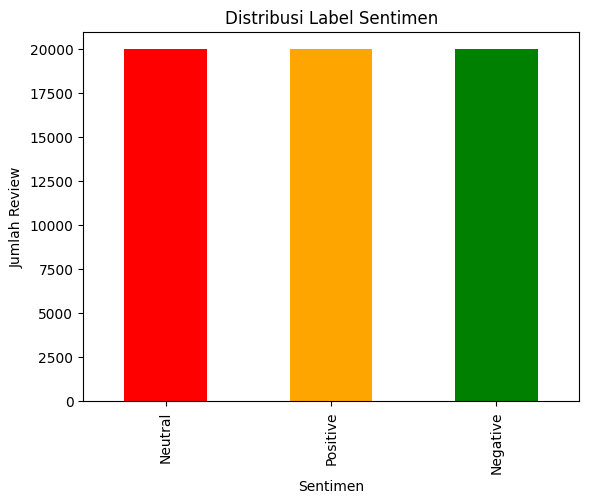

In [14]:
sentiment_counts = df3["sentiment_label"].value_counts()
sentiment_counts.plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Distribusi Label Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Review")
plt.show()

## Distribusi Panjang Review per Label Sentimen

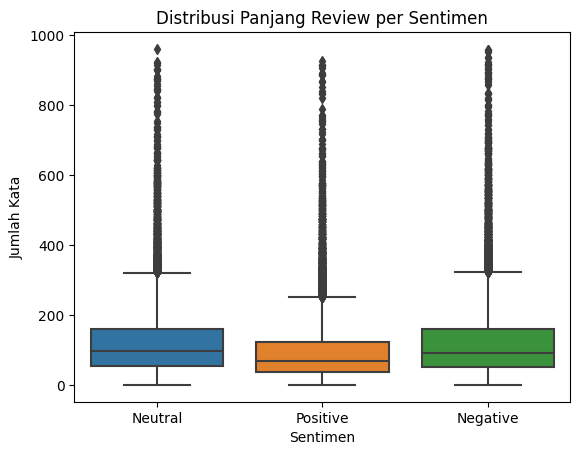

In [15]:
df3["text_length"] = df3["text"].str.split().apply(len)

sns.boxplot(x="sentiment_label", y="text_length", data=df3)
plt.title("Distribusi Panjang Review per Sentimen")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Kata")
plt.show()

Review negative dan neutral cenderung lebih panjang dibanding positive. Artinya, pengguna yang memberikan ulasan negatif biasanya menulis lebih detail untuk menjelaskan keluhannya, sedangkan review positif cenderung lebih singkat.

## Kelas Paling Umum per Sentimen (Word Frequency)

In [16]:
for label in df3["sentiment_label"].unique():
    words = " ".join(df3[df3["sentiment_label"] == label]["text"]).lower().split()
    word_freq = Counter([w for w in words if w not in STOPWORDS])
    print(f"10 kata paling sering muncul di label {label}:", word_freq.most_common(10), "\n")

10 kata paling sering muncul di label Neutral: [('food', 12917), ('good', 11067), ('place', 9125), ('really', 6995), ('one', 6040), ('service', 5934), ('ordered', 5708), ('-', 5277), ('go', 5109), ('pretty', 5078)] 

10 kata paling sering muncul di label Positive: [('food', 9813), ('great', 9006), ('place', 8299), ('good', 7440), ('really', 5238), ('one', 5077), ('-', 4408), ('go', 4345), ('service', 4310), ('will', 4195)] 

10 kata paling sering muncul di label Negative: [('food', 13872), ('place', 8181), ('one', 7208), ('ordered', 7144), ('good', 6015), ('us', 5921), ('order', 5858), ('service', 5775), ('time', 5522), ('got', 5399)] 



## N-Gram

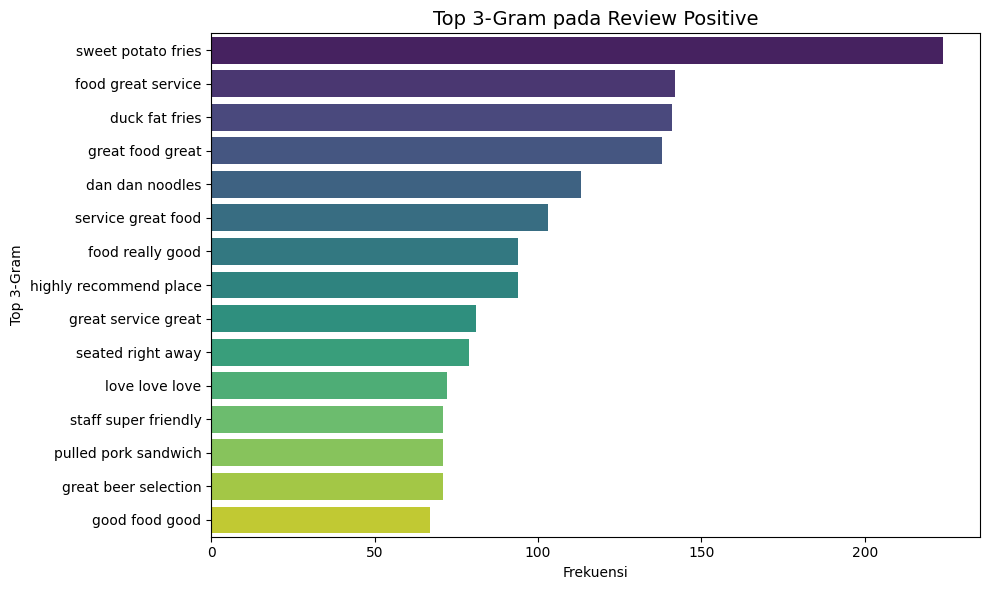

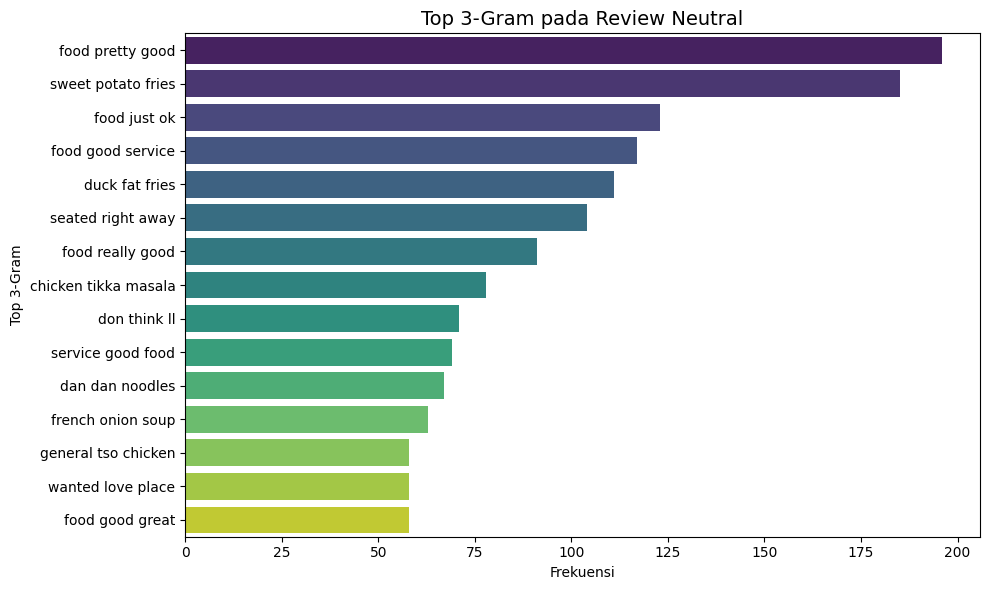

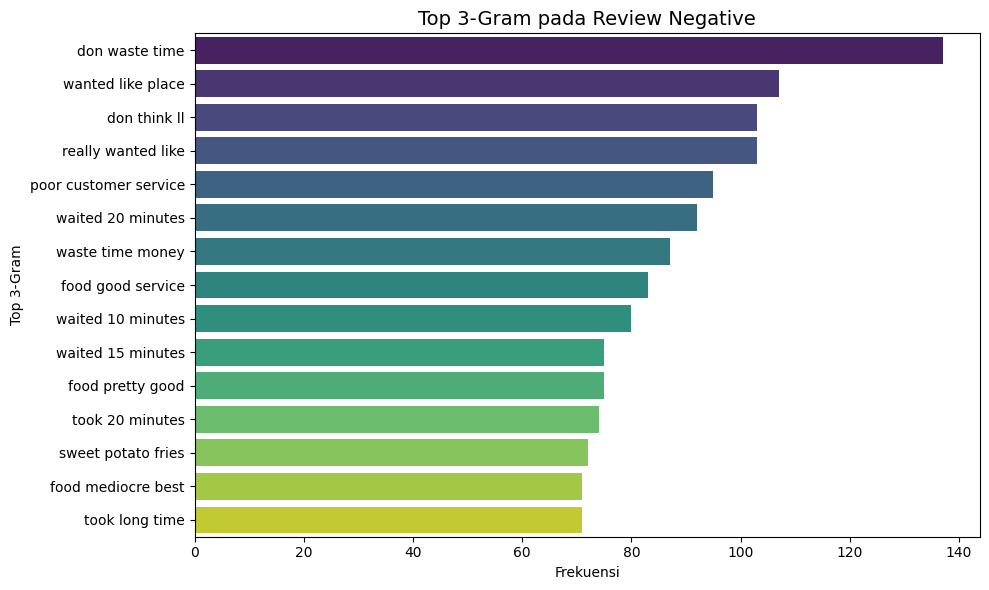

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(df3, sentiment, n=3, top_k=15):
    reviews = df3[df3["sentiment_label"] == sentiment]["text"]
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(reviews)
    ngrams = pd.DataFrame({
        f'{n}-gram': vectorizer.get_feature_names_out(),
        'Frequency': X.sum(axis=0).A1
    }).sort_values(by='Frequency', ascending=False).head(top_k)

    plt.figure(figsize=(10,6))
    sns.barplot(y=f'{n}-gram', x='Frequency', data=ngrams, palette='viridis')
    plt.title(f"Top {n}-Gram pada Review {sentiment.capitalize()}", fontsize=14)
    plt.xlabel("Frekuensi")
    plt.ylabel(f"Top {n}-Gram")
    plt.tight_layout()
    plt.show()

for s in ["Positive", "Neutral", "Negative"]:
    plot_top_ngrams(df3, s)

## WordCloud per Label Sentimen

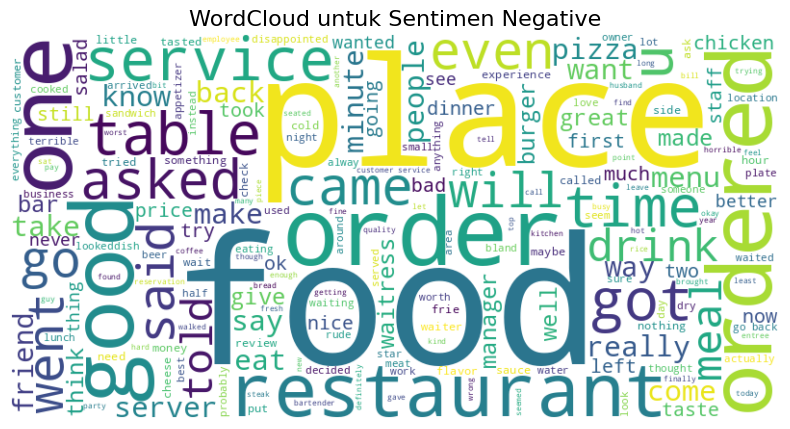

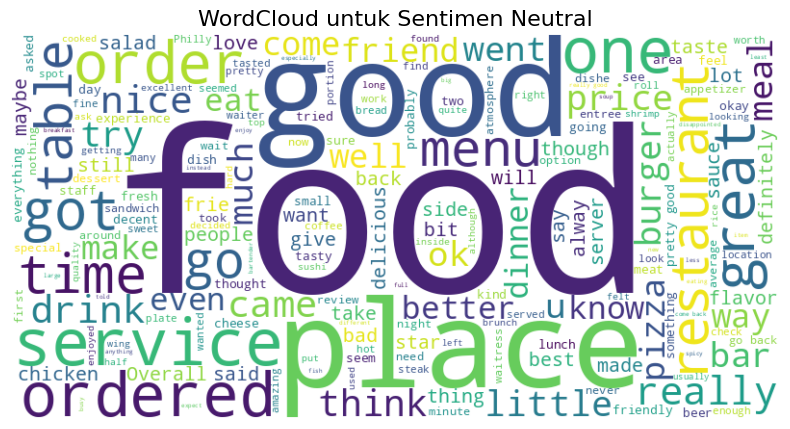

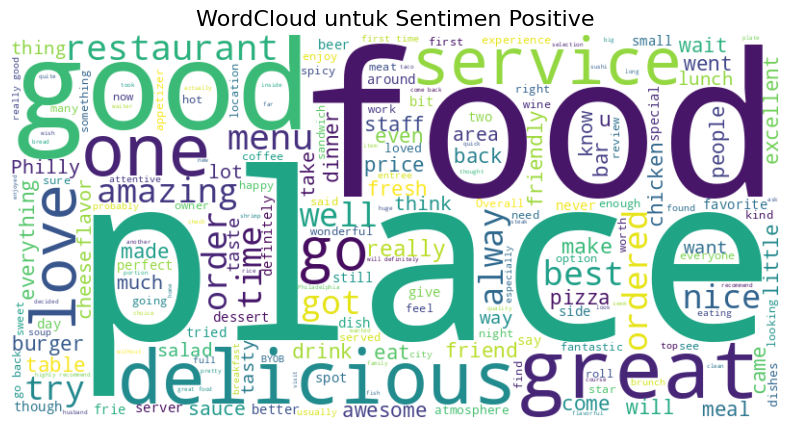

In [18]:
sentiments = ["Negative", "Neutral", "Positive"]

for name in sentiments:
    subset = df3[df3["sentiment_label"] == name]["text"].dropna()
    if subset.empty:
        print(f"Tidak ada data untuk sentimen {name}, dilewati.")
        continue
    
    text = " ".join(subset)
    wc = WordCloud(width=800, height=400, background_color="white", stopwords=STOPWORDS).generate(text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud untuk Sentimen {name}", fontsize=16)
    plt.show()

WordCloud menampilkan kata-kata yang paling sering muncul pada setiap label sentimen. Makin besar kata tersebut maka makin sering kata itu muncul.

1. WordCloud Negative
    Kata seperti “food”, “place”, “order”, “service” tetap muncul besar yang artinya meskipun reviewnya negatif, orang tetap sering menyebut hal-hal umum seperti makanan dan tempat. Untuk yang konteksnya negatif, misalnya “bad service”, “cold food”, “long wait” tidak ditampilkan karena WordCloud menampilkan kata saja.

2. WordCloud Neutral
    Kata “food”, “good”, “place”, “service”, "love" juga muncul dominan yang menandakan review netral seringkali berupa komentar yang deskriptif atau campuran, misalnya “food was okay”, “service fine”. Tidak terlalu banyak juga kata emosional (seperti bad atau excellent)

3. WordCloud Positive
    Kata “food”, “great”, “place”, “delicious”, “good” muncul sangat besar yang berarti review positif cenderung menggunakan kata dengan nada positif dan pujian. Sesuai dengan ekspektasi, orang yang puas akan sering menyebut kata seperti great, good, delicious, nice.

## Distribusi Review Berdasarkan Rating

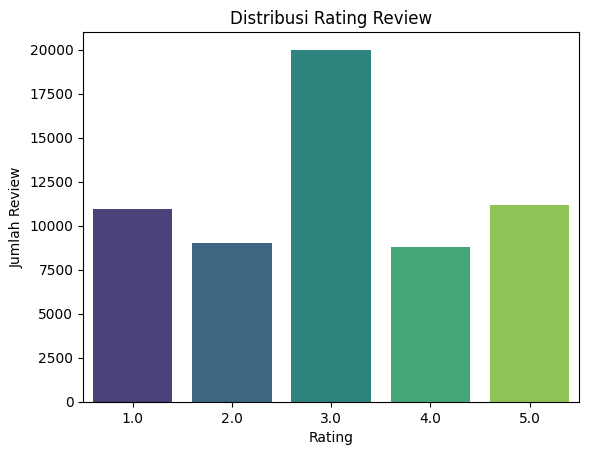

In [19]:
sns.countplot(x="review_stars", data=df3, palette="viridis")
plt.title("Distribusi Rating Review")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.show()

Data menunjukkan bahwa sebagian besar pelanggan memberikan penilaian positif (4–5 bintang). Artinya pula review pelanggan terhadap restoran cenderung baik, meskipun tetap ada sebagian kecil ulasan negatif

## Jumlah Review per Kota

In [20]:
city_counts = (
    df3["city"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "city", "city": "city"})
)

print("Jumlah Review per Kota")
display(city_counts)

Jumlah Review per Kota


,city,count
0,Philadelphia,38093
1,West Chester,1084
2,Media,930
3,Exton,928
4,Springfield,772
...,...,...
159,Dresher,1
160,Garnet Valley,1
161,Red Hill,1
162,WEST CHESTER,1


## Urutan Review Tertinggi per Kota

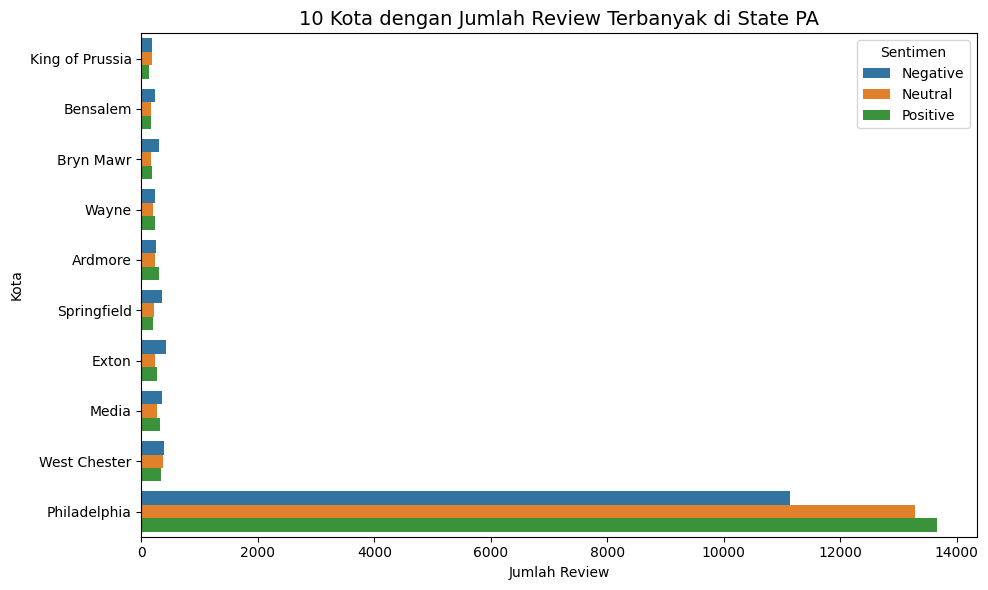

In [21]:
city_sentiment = (
    df3.groupby(["city", "sentiment_label"])
      .size()
      .reset_index(name="count")
)

top10_cities = (
    city_sentiment.groupby("city")["count"]
    .sum()
    .nlargest(10)
    .index
)

city_sentiment_top10 = city_sentiment[city_sentiment["city"].isin(top10_cities)]

city_order = (
    city_sentiment_top10.groupby("city")["count"]
    .sum()
    .sort_values()
    .index
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=city_sentiment_top10,
    y="city", x="count",
    hue="sentiment_label",
    order=city_order,
    orient="h"
)

plt.title("10 Kota dengan Jumlah Review Terbanyak di State PA", fontsize=14)
plt.xlabel("Jumlah Review")
plt.ylabel("Kota")
plt.legend(title="Sentimen")
plt.tight_layout()
plt.show()